In [35]:
### Dataset process 
"""
   Here we want to format the hasty annotation data and make sure everything is ready for the YOLOv11 model.
   We'll go through several steps before the data is correclty processed, each will be detailed and explained.
  
"""

"\n   Here we want to format the hasty annotation data and make sure everything is ready for the YOLOv11 model.\n   We'll go through several steps before the data is correclty processed, each will be detailed and explained.\n  \n"

In [6]:
# Importing the necessary libraries
import os
import json
import pandas as pd
from tqdm import tqdm  # Progress bar for loops, to see how long it takes to process the data (it's one of my favorite :))
import cv2 #OpenCV for image processing 
import numpy as np # array manipulation
import matplotlib.pyplot as plt

In [ ]:
# Define paths required for annotations and image processing 
coco_json_path = r"C:\Users\Lucy\Desktop\REDUCE\final_data.json"
output_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"
csv_path = r"C:\Users\Lucy\Desktop\REDUCE\annotations.csv"
class_path = r"C:\Users\Lucy\Desktop\REDUCE\classes.txt"
image_dir = r"C:\Users\Lucy\Desktop\REDUCE\Phototheque\CNT-Canthidermis-maculata"

In [1]:
# step to correct the hasty.ai classes    
"Hasti.ai classes are not startinf from 0, however YOLO11 requieres the classes to start from 0, so we need to reindex the classes in the JSON file."  

import json
import os

def reindex_coco_categories(input_json, output_json):
    """
    it replace the old ID strating from 0
    """
    # Load json file
    with open(input_json, "r", encoding="utf-8") as f:
        coco_data = json.load(f)

    if "categories" not in coco_data or "annotations" not in coco_data:
        raise KeyError("Json does not contrain ' categories or 'annotations'")

    # Build mapping old_id -> new_id
    old_ids = [cat["id"] for cat in coco_data["categories"]]
    old_ids_sorted = sorted(old_ids)

    # Remapping : ex. 1->0, 2->1, 5->2, etc.
    old_to_new = {}
    for new_id, old_id in enumerate(old_ids_sorted):
        old_to_new[old_id] = new_id

    # Refresh categories
    for cat in coco_data["categories"]:
        old_id = cat["id"]
        cat["id"] = old_to_new[old_id]  # remplace new ID

    # Refresh annotations
    for ann in coco_data["annotations"]:
        old_cat_id = ann["category_id"]
        if old_cat_id in old_to_new:
            ann["category_id"] = old_to_new[old_cat_id]
        else:
            pass

    # Write new jason file
    with open(output_json, "w", encoding="utf-8") as f:
        json.dump(coco_data, f, indent=2, ensure_ascii=False)

    print(f"New file save in: {output_json}")
if __name__ == "__main__":
    input_json_path = r"C:\Users\Lucy\Desktop\REDUCE\dataset.json"
    output_json_path = r"C:\Users\Lucy\Desktop\REDUCE\dataset_coco_reindexed.json"

    reindex_coco_categories(input_json_path, output_json_path)


New file save in: C:\Users\Lucy\Desktop\REDUCE\dataset_coco_reindexed.json


In [2]:
"""load the reindexed coco json file"""
coco_json_path = r"C:\Users\Lucy\Desktop\REDUCE\dataset_coco_reindexed.json"

In [3]:
# Here you define a function to load the coco jason file, and check if the keys are present
"""We use a re usable function so we can use it in the future if we need to load another json file"""
def load_coco_json(path):
    """Load COCO JSON and check essential keys."""
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for key in ["categories", "images", "annotations"]:
        if key not in data:
            raise KeyError(f"Key '{key}' missing in {path}")
    return data


In [4]:
def extract_classes(coco_json_path, output_txt_path):
    """
    Extract the classes ffrom the jason path et save them into a text file.
    """
    # Load coco data
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    # get categories
    categories = coco_data.get("categories", [])
    if not categories:
        print("Aucune catégorie trouvée dans le fichier COCO.")
        return

    # Write output
    with open(output_txt_path, 'w', encoding='utf-8') as f:
        for cat in categories:
            f.write(f"{cat['id']}: '{cat['name']}'\n")
    print(f"✅ {len(categories)} classes extraites dans {output_txt_path}")

if __name__ == "__main__":
    coco_json_path = r"C:\Users\Lucy\Desktop\REDUCE\dataset_coco_reindexed.json"   # Remplacez par le chemin de votre fichier COCO JSON
    output_txt_path = r"classes.txt"              # Chemin du fichier de sortie
    extract_classes(coco_json_path, output_txt_path)

✅ 125 classes extraites dans classes.txt


In [7]:
from tqdm import tqdm
def convert_coco_to_yolo(coco_data, output_dir, csv_path, class_mapping):
    """
    Convert COCO segmentation to YOLO-compatible segmentation (normalized)
    and generate .txt label files + a CSV for metadata.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    image_dict = {img['id']: img for img in coco_data['images']}
    annotation_dict = {}

    file_names, species_ids, species_names, segmentations = [], [], [], []

    for ann in tqdm(coco_data['annotations'], desc="Conversion COCO -> YOLO"):
        image_id = ann['image_id']
        if image_id not in image_dict:
            continue
        
        image_info = image_dict[image_id]
        image_name = image_info['file_name']
        w, h = image_info['width'], image_info['height']

        label_file = os.path.join(output_dir, os.path.splitext(image_name)[0] + '.txt')
        
        cat_id = ann['category_id']
        # For class_id, either use cat_id directly, or if there's a re-map, do that here
        class_id = cat_id  # Modify if you need a different mapping

        species_name = class_mapping.get(class_id, "Unknown")

        seg = ann.get("segmentation", [])
        # Debug : afficher quelques segmentations
        if not seg:
            # Si aucune segmentation n'est présente, on passe à l'annotation suivante.
            # Vous pouvez activer le print ci-dessous pour déboguer.
            # print(f"Annotation {ann['id']} has no segmentation data.")
            continue
        
        # Vérifier que seg est une liste de coordonnées (et non du RLE par exemple)
        for segment in seg:
            if not isinstance(segment, list) or len(segment) < 6:
                # Ce segment n'est pas un polygone valide
                # print(f"Annotation {ann['id']} segmentation is not a valid polygon: {segment}")
                continue

            normalized_coords = []
            for i in range(0, len(segment), 2):
                x_norm = segment[i] / w
                y_norm = segment[i+1] / h
                normalized_coords.append(f"{x_norm:.6f} {y_norm:.6f}")
            line = f"{class_id} {' '.join(normalized_coords)}"
            
            annotation_dict.setdefault(label_file, []).append(line)
            file_names.append(image_name)
            species_ids.append(class_id)
            species_names.append(species_name)
            segmentations.append(line)
    
    # Write .txt files
    if annotation_dict:
        for fpath, lines in annotation_dict.items():
            with open(fpath, 'w', encoding='utf-8') as f:
                f.write("\n".join(lines) + "\n")
        print(f"[INFO] Wrote {len(annotation_dict)} label files in {output_dir}")
    else:
        print("[INFO] No annotations were converted. Check your COCO data and segmentation format.")
    
    # Write CSV
    df = pd.DataFrame({
        'file_name': file_names,
        'species_id': species_ids,
        'species_name': species_names,
        'segmentation': segmentations
    })
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"[INFO] Wrote metadata CSV: {csv_path}")

# Exemple d'utilisation :
if __name__ == "__main__":
    # Charger votre fichier COCO (JSON)
    coco_json_path = r"C:\Users\Lucy\Desktop\REDUCE\dataset_coco_reindexed.json"  # Remplacez par le chemin réel
    with open(coco_json_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    output_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"  # Dossier où écrire les .txt
    csv_path = r"C:\Users\Lucy\Desktop\REDUCE\annotations.csv"
    
    # Charger ou définir un mapping de classes (exemple simple)
    # Supposons que votre COCO contient un champ "categories" avec "id" et "name"
    class_mapping = {cat['id']: cat['name'] for cat in coco_data.get("categories", [])}
    
    convert_coco_to_yolo(coco_data, output_dir, csv_path, class_mapping)

Conversion COCO -> YOLO: 100%|██████████| 2888/2888 [00:00<00:00, 22091.87it/s]


[INFO] Wrote 2002 label files in C:\Users\Lucy\Desktop\REDUCE\test
[INFO] Wrote metadata CSV: C:\Users\Lucy\Desktop\REDUCE\annotations.csv


In [8]:
"""The issue with the hasty segmentation point is that they use the true pixels values of the image however the yolo model use relative pixels 
values. So we need to convert the annotation so that the segmentation value is between 0 and 1.""" 
def convert_coco_to_yolo(coco_data, output_dir, csv_path, class_mapping):
    """
    Convert COCO segmentation to YOLO-compatible segmentation (normalized)
    and generate .txt label files + a CSV for metadata.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    image_dict = {img['id']: img for img in coco_data['images']}
    annotation_dict = {}

    file_names, species_ids, species_names, segmentations = [], [], [], []

    for ann in tqdm(coco_data['annotations'], desc="Conversion COCO -> YOLO"):
        image_id = ann['image_id']
        if image_id not in image_dict:
            continue
        
        image_info = image_dict[image_id]
        image_name = image_info['file_name']
        w, h = image_info['width'], image_info['height']

        label_file = os.path.join(output_dir, os.path.splitext(image_name)[0] + '.txt')
        
        cat_id = ann['category_id']
        # For class_id, either use cat_id directly, or if there's a re-map, do that here
        class_id = cat_id  # If you re-map (like sorted/starting at 0), handle that above

        species_name = class_mapping.get(class_id, "Unknown")

        # If there's segmentation
        seg = ann.get("segmentation", [])
        if seg:
            for segment in seg:
                # Normalize polygon coords
                normalized_coords = []
                for i in range(0, len(segment), 2):
                    x_norm = segment[i]   / w
                    y_norm = segment[i+1] / h
                    normalized_coords.append(f"{x_norm:.6f} {y_norm:.6f}")
                line = f"{class_id} {' '.join(normalized_coords)}"
                
                annotation_dict.setdefault(label_file, []).append(line)
                file_names.append(image_name)
                species_ids.append(class_id)
                species_names.append(species_name)
                segmentations.append(line)
    
    # Write .txt files
    for fpath, lines in annotation_dict.items():
        with open(fpath, 'w', encoding='utf-8') as f:
            f.write("\n".join(lines) + "\n")
    
    # Write CSV
    df = pd.DataFrame({
        'file_name': file_names,
        'species_id': species_ids,
        'species_name': species_names,
        'segmentation': segmentations
    })
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"[INFO] Wrote {csv_path}")

In [9]:
# Test of the normalization process 
"""This code allows to test the normalization process of the segmentation points.
 It will display the original and normalized points for a given annotation. Eventualy if you see that the shape of the object is distorted
and do not fit the image yo might reconsider the normalization process """
def test_segmentation_visual(image_path, label_path):
    """
    Simple function to read an image + YOLO label, draw polygons, and show them in matplotlib.
    """
    if not os.path.isfile(image_path):
        print(f"Image not found: {image_path}")
        return
    if not os.path.isfile(label_path):
        print(f"Label file not found: {label_path}")
        return

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3:
            continue
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        points = []
        for i in range(0, len(coords), 2):
            x_p = int(coords[i] * w)
            y_p = int(coords[i+1] * h)
            points.append((x_p, y_p))
        # Draw polygon
        pts_np = np.array(points, dtype=np.int32)
        pts_np = pts_np.reshape((-1, 1, 2))
        cv2.polylines(image, [pts_np], isClosed=True, color=(255,0,0), thickness=2)

    plt.figure(figsize=(8,6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Segmentation Visualization")
    plt.show()

if __name__ == "__main__":
    # Or in the last cell of your notebook:
    coco_data = load_coco_json(coco_json_path)
    create_or_update_classes_file(coco_data, class_path)
    class_mapping = read_class_mapping(class_path)

    convert_coco_to_yolo(
        coco_data=coco_data,
        output_dir=output_dir,
        csv_path=csv_path,
        class_mapping=class_mapping
    )

    # Example test on a single image
    test_img = "CNT_23f04435b2ae4114497438d13de0fa60_MOEC_IRD.JPG"
    img_path = os.path.join(image_dir, test_img)
    label_path = os.path.join(output_dir, os.path.splitext(test_img)[0] + ".txt")
    test_segmentation_visual(img_path, label_path)

NameError: name 'create_or_update_classes_file' is not defined

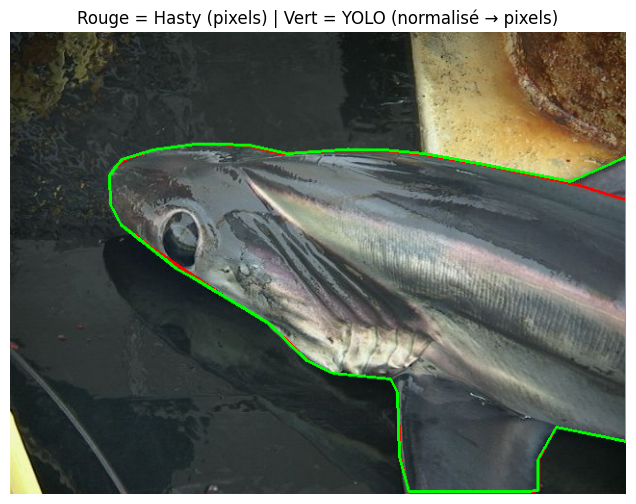

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_yolo_seg_file(label_path):
    """
    Lit un fichier YOLO.txt qui contient *possiblement plusieurs polygones*.
    Chaque ligne : class_id x1_norm y1_norm x2_norm y2_norm ...
    Retourne un tableau de polygones,
    ex.: [ [(x1,y1), (x2,y2), ...],  # polygon 1
           [(x1,y1), (x2,y2), ...] ] # polygon 2 (s’il y a plusieurs segments)
    """
    polygons = []
    if not os.path.isfile(label_path):
        print(f"Fichier YOLO introuvable: {label_path}")
        return polygons

    with open(label_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3:
            continue  # ignorer les lignes vides/mal formées

        # On ignore la class_id (parts[0]), on ne s’en sert pas ici
        coords = list(map(float, parts[1:]))

        polygon = []
        for i in range(0, len(coords), 2):
            x_norm = coords[i]
            y_norm = coords[i+1]
            polygon.append((x_norm, y_norm))
        polygons.append(polygon)

    return polygons

def compare_hasty_and_yolo(image_path, hasty_coords, yolo_coords_list):
    """
    - image_path : chemin de l'image
    - hasty_coords : liste de points (x, y) en pixels [un SEUL polygone brut].
    - yolo_coords_list : liste de polygones YOLO -> [ [(xn,yn), (xn,yn), ...], [...], ...]
      où chaque polygone est en coordonnées normalisées [0..1].
    """

    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Impossible de charger l'image: {image_path}")
        return
    # Convertir BGR -> RGB (pour affichage Matplotlib)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # 1) Dessiner la segmentation brute "Hasty" en ROUGE
    if hasty_coords:
        hasty_np = np.array(hasty_coords, dtype=np.int32).reshape((-1,1,2))
        cv2.polylines(image, [hasty_np], isClosed=True, color=(255,0,0), thickness=2)

    # 2) Pour chaque polygone YOLO, convertit en pixels et dessine en VERT
    for polygon_norm in yolo_coords_list:
        points = []
        for (xn, yn) in polygon_norm:
            x_abs = int(xn * w)
            y_abs = int(yn * h)
            points.append((x_abs, y_abs))

        polygon_np = np.array(points, dtype=np.int32).reshape((-1,1,2))
        cv2.polylines(image, [polygon_np], isClosed=True, color=(0,255,0), thickness=2)

    # Affichage
    plt.figure(figsize=(8,6))
    plt.imshow(image)
    plt.title("Rouge = Hasty (pixels) | Vert = YOLO (normalisé → pixels)")
    plt.axis("off")
    plt.show()


# ------------------------------------------------------------------------
# Exemple d'utilisation
# ------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Spécifier vos chemins réels
    image_path = r"C:\Users\Lucy\Desktop\REDUCE\Phototheque\BTH-Alopias-superciliosus\BTH_5f14ff45e3b23836711e4ca09b8a6375_SHARP_IRD.jpeg"
    label_path = r"C:\Users\Lucy\Desktop\REDUCE\test\BTH_5f14ff45e3b23836711e4ca09b8a6375_SHARP_IRD.txt"

    # 2) Exemples fictifs : les coords “brute Hasty” en pixels
    #    (à remplacer par les vrais points extraits de Hasty/Coco)
    hasty_polygon_pixels = [
          (192, 116), (148, 122), (117, 133), (108, 141), (103, 149),
        (104, 179), (115, 200), (150, 226), (220, 273), (268, 302),
        (309, 341), (335, 354), (395, 360), (402, 374), (405, 441),
        (414, 478), (536, 478), (549, 476), (549, 444), (567, 410),
        (640, 425), (640, 174), (591, 159), (489, 137), (430, 127),
        (388, 123), (335, 123), (279, 126), (248, 118), (216, 116)
    ]

    # 3) Lire le (ou les) polygone(s) YOLO [0..1] depuis le fichier
    yolo_polygons = read_yolo_seg_file(label_path)

    # 4) Comparer et visualiser
    compare_hasty_and_yolo(
        image_path=image_path,
        hasty_coords=hasty_polygon_pixels,
        yolo_coords_list=yolo_polygons
    )


In [11]:
"""this is an additional function to check is the class id does correspond the hasty annotation, here it print the class liked to some images.
use a species that has few annotations to see if the segmentation on hasty match the class id in the annotation txt.
 If yes it means the normalization and class assignment worked correctly  """
"for instance I know that ID 17 is ccp so i checdk if it does match"

# Définition du dossier contenant les fichiers d'annotations YOLO
labels_folder = r"C:\Users\Lucy\Desktop\REDUCE\test"

# Parcourir tous les fichiers du dossier
print("\n📂 Fichiers contenant la classe '17' :")
for filename in os.listdir(labels_folder):
    file_path = os.path.join(labels_folder, filename)

    # Vérifier si c'est bien un fichier et non un dossier
    if not os.path.isfile(file_path):
        continue  # Ignore les dossiers

    # Lire le fichier d'annotation
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Vérifier si au moins une ligne commence par "17 "
    found = any(line.startswith("17 ") for line in lines)

    if found:
        print(f"✅ {filename}")


📂 Fichiers contenant la classe '17' :
✅ CCP_b65766e7cdd80b1a7dcfcd70058dccf3_KOUAKOU_ORTHONGEL.txt


ID | Nom d'espèce                      | Nombre de segmentations
---|------------------------------------|------------------------
 0 | RRY-Rhina-ancylostoma          |         10
 1 | 3DEY-Diodon-eydouxii           |         32
 2 | ALB-Thunnus-alalunga           |          8
 3 | ALM-Aluterus-monoceros         |         31
 4 | ALN-Aluterus-scriptus          |         21
 5 | ALS-Carcharhinus-albimarginatus |          2
 6 | ALX-Alepisaurus-ferox          |          1
 7 | BAF-Ablennes-hians             |         38
 8 | BAO-Platax-teira               |         27
 9 | BET-Thunnus-obesus             |         26
10 | BLM-Istiompax-indica           |         35
11 | BLT-Auxis-rochei               |          9
12 | BSH-Prionace-glauca            |         46
13 | BTH-Alopias-superciliosus      |         24
14 | CCE-Carcharhinus-leucas        |          6
15 | CCF-Carcharhinus-amboinensis   |          4
16 | CCL-Carcharhinus-limbatus      |         29
17 | CCP-Carcharhinus-plumbeus     

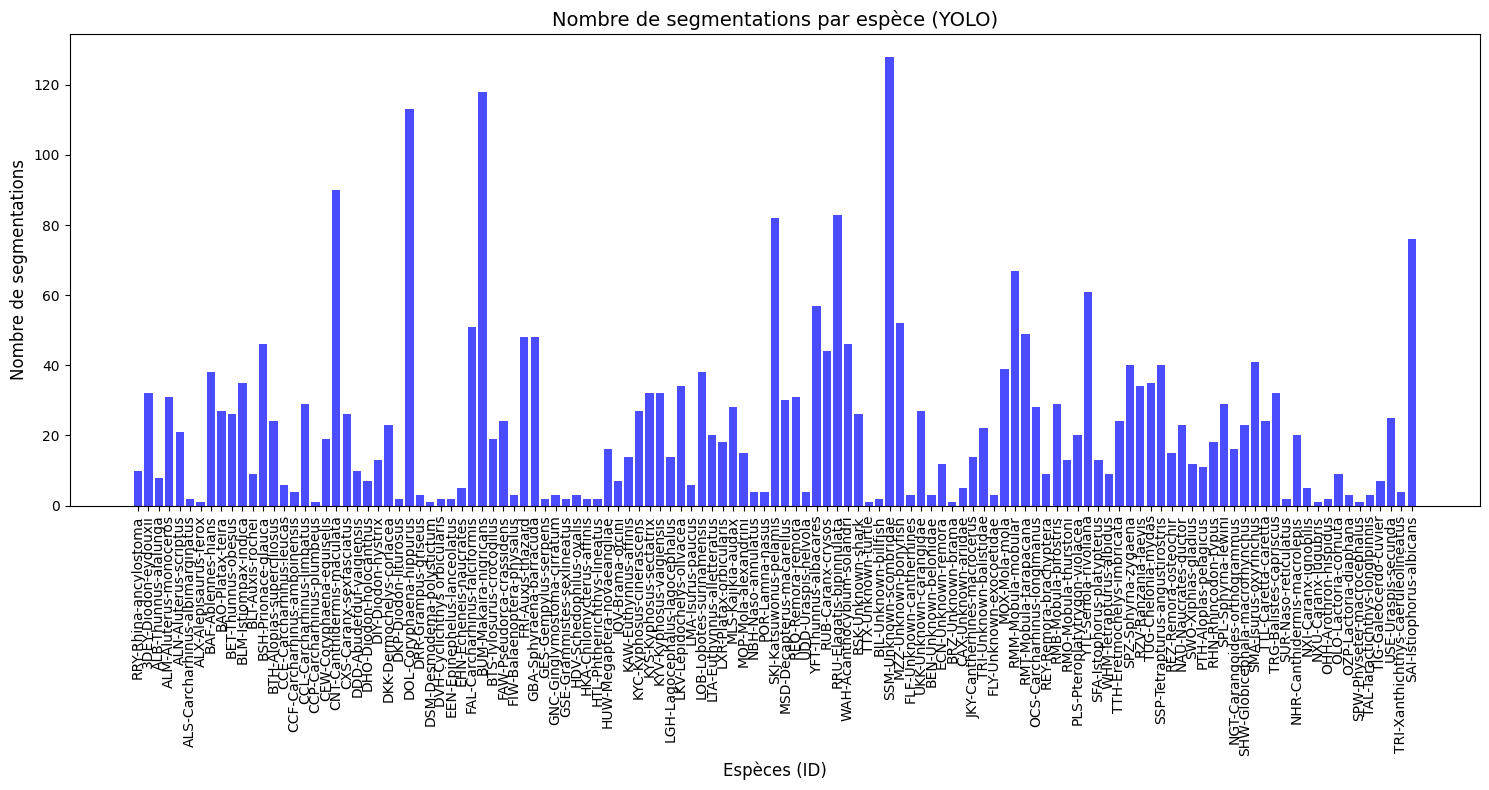

In [12]:
# Step to calculate the number of segmentations/annotations per class
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# -------------------------------------------------------------------------
# 1) Chemins et configuration
# -------------------------------------------------------------------------
labels_dir   = r"C:\Users\Lucy\Desktop\REDUCE\test"     # Dossier contenant les .txt YOLO
classes_path = r"C:\Users\Lucy\Desktop\REDUCE\classes.txt"  # Fichier qui mappe ID -> nom

# -------------------------------------------------------------------------
# 2) Lecture de classes.txt -> dict {id: species_name}
# -------------------------------------------------------------------------
id_to_name = {}
with open(classes_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Format attendu : "0: 'NomDeClasse'"
        # On va parser l'ID et le nom
        line = line.strip()
        if not line:
            continue
        # Exemple de ligne :  0: 'Canthidermis-maculata'
        parts = line.split(":")
        if len(parts) < 2:
            continue
        
        # id_str = "0", name_part = " 'Canthidermis-maculata'"
        id_str = parts[0].strip()
        name_part = parts[1].strip()
        
        # Convertir l'id en int
        try:
            class_id = int(id_str)
        except ValueError:
            continue
        
        # Retirer les éventuels guillemets simples
        name_part = name_part.strip()
        # S'il y a un "'..." on l'enlève
        if name_part.startswith("'") and name_part.endswith("'"):
            name_part = name_part[1:-1]
        
        id_to_name[class_id] = name_part

# -------------------------------------------------------------------------
# 3) Compter le nombre de segmentations par ID
# -------------------------------------------------------------------------
segments_count = defaultdict(int)

for file_name in os.listdir(labels_dir):
    if file_name.lower().endswith(".txt"):
        label_path = os.path.join(labels_dir, file_name)
        
        with open(label_path, 'r', encoding='utf-8') as lf:
            for line in lf:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                # Format YOLO segmentation :  class_id x1 y1 x2 y2 ...
                try:
                    class_id = int(parts[0])
                except ValueError:
                    continue
                # On incrémente le nombre de segments pour ce class_id
                segments_count[class_id] += 1

# -------------------------------------------------------------------------
# 4) Afficher un tableau récapitulatif
# -------------------------------------------------------------------------
print("ID | Nom d'espèce                      | Nombre de segmentations")
print("---|------------------------------------|------------------------")
all_ids_sorted = sorted(segments_count.keys())
for cid in all_ids_sorted:
    name = id_to_name.get(cid, f"Unknown_ID_{cid}")
    count = segments_count[cid]
    print(f"{cid:2d} | {name:30s} | {count:10d}")

# -------------------------------------------------------------------------
# 5) Créer un histogramme (diagramme en barres)
# -------------------------------------------------------------------------
# Construire la liste d'IDs ordonnée et la liste de counts
x_ids   = []
x_names = []
y_counts = []

for cid in all_ids_sorted:
    x_ids.append(cid)
    x_names.append(id_to_name.get(cid, f"Unknown_{cid}"))
    y_counts.append(segments_count[cid])

plt.figure(figsize=(15, 8))  # Ajustez la taille pour avoir de grands axes
plt.bar(range(len(x_ids)), y_counts, color='blue', alpha=0.7)

plt.xlabel("Espèces (ID)", fontsize=12)
plt.ylabel("Nombre de segmentations", fontsize=12)
plt.title("Nombre de segmentations par espèce (YOLO)", fontsize=14)

# Mettre les noms d'espèces sur l'axe X
plt.xticks(range(len(x_ids)), x_names, rotation=90)
plt.tight_layout()
plt.show()

🔝 Top 10 classes with the most annotations:
ID | Species Name                      | Number of Annotations
---|-----------------------------------|----------------------
72 | SSM-Unknown-scombridae         |        128
33 | BUM-Makaira-nigricans          |        118
26 | DOL-Coryphaena-hippurus        |        113
19 | CNT-Canthidermis-maculata      |         90
67 | RRU-Elagatis-bipinnulata       |         83
61 | SKJ-Katsuwonus-pelamis         |         82
124 | SAI-Istiophorus-albicans       |         76
84 | RMM-Mobula-mobular             |         67
91 | YTL-Seriola-rivoliana          |         61
65 | YFT-Thunnus-albacares          |         57
73 | MZZ-Unknown-bonyfish           |         52
32 | FAL-Carcharhinus-falciformis   |         51
85 | RMT-Mobula-tarapacana          |         49
38 | GBA-Sphyraena-barracuda        |         48
37 | FRI-Auxis-thazard              |         48
12 | BSH-Prionace-glauca            |         46
68 | WAH-Acanthocybium-solandri     |        

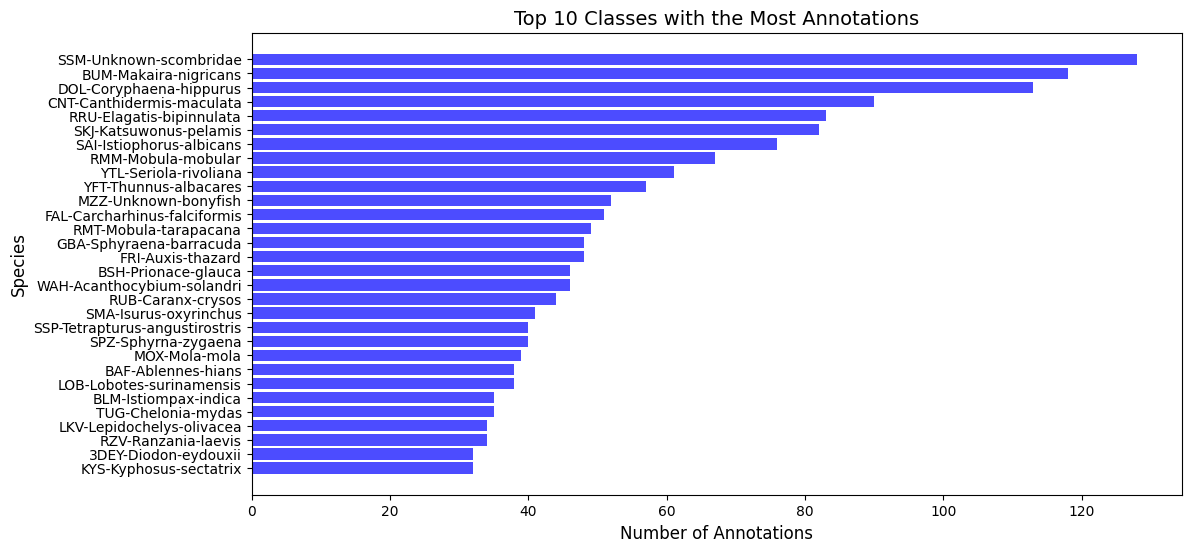

In [13]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# 📂 **Paths to your dataset**
labels_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"  # Change this to the correct labels directory
classes_path = r"C:\Users\Lucy\Desktop\REDUCE\classes.txt"  # Path to classes.txt

# ✅ **Step 1: Read `classes.txt` and create a mapping {id: species_name}**
id_to_name = {}
with open(classes_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(":")
        if len(parts) < 2:
            continue

        id_str = parts[0].strip()
        name_part = parts[1].strip().strip("'")  # Remove quotes around the name

        try:
            class_id = int(id_str)
            id_to_name[class_id] = name_part
        except ValueError:
            continue

# ✅ **Step 2: Count the number of annotations per class**
annotations_count = defaultdict(int)

for file_name in os.listdir(labels_dir):
    if file_name.lower().endswith(".txt"):  # Ensure it's a YOLO label file
        label_path = os.path.join(labels_dir, file_name)

        with open(label_path, 'r', encoding='utf-8') as lf:
            for line in lf:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                try:
                    class_id = int(parts[0])  # YOLO format: class_id x1 y1 x2 y2 ...
                    annotations_count[class_id] += 1
                except ValueError:
                    continue

# ✅ **Step 3: Find the Top 10 Most Annotated Classes**
top_10_classes = sorted(annotations_count.items(), key=lambda x: x[1], reverse=True)[:30]

# ✅ **Step 4: Print the results**
print("🔝 Top 10 classes with the most annotations:")
print("ID | Species Name                      | Number of Annotations")
print("---|-----------------------------------|----------------------")
for cid, count in top_10_classes:
    name = id_to_name.get(cid, f"Unknown_{cid}")
    print(f"{cid:2d} | {name:30s} | {count:10d}")

# ✅ **Step 5: Visualize the results**
x_labels = [id_to_name.get(cid, f"Unknown_{cid}") for cid, _ in top_10_classes]
y_counts = [count for _, count in top_10_classes]

plt.figure(figsize=(12, 6))
plt.barh(x_labels, y_counts, color='blue', alpha=0.7)
plt.xlabel("Number of Annotations", fontsize=12)
plt.ylabel("Species", fontsize=12)
plt.title("Top 10 Classes with the Most Annotations", fontsize=14)
plt.gca().invert_yaxis()  # Invert order to have most annotated class on top
plt.show()


Note: you may need to restart the kernel to use updated packages.
Channels:
 - conda-forge
 - defaults
Platform: win-64

Note: you may need to restart the kernel to use updated packages.
Nombre total d'images annotées : 2002
Nombre total d'espèces        : 123


Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000163A5D17560>: Failed to resolve 'repo.anaconda.com' ([Errno 11001] getaddrinfo failed)")': /pkgs/main/noarch/repodata.json.zst

Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000163A5D17AA0>: Failed to resolve 'repo.anaconda.com' ([Errno 11001] getaddrinfo failed)")': /pkgs/main/win-64/repodata.json.zst

Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000163A5D17B30>: Failed to resolve 'repo.anaconda.com' ([Errno 11001] getaddrinfo failed)")': /pkgs/msys2/win-64/repodata.json.zst

Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=


Split initial : 1603 images en train, 399 en val.
Après post-traitement : 1651 images en train, 351 en val.
⚠️ Image introuvable : GES_08845ae2eb13d7bf674e2a39e51c4037_GOUE_ORTHONGEL.JPG
✅ Copie des fichiers terminée !

Détails par espèce :

 i | Espèce (ID)  | TrainCount | ValCount | %Train(espèce) | %Val(espèce) | %Train(dset) | %Val(dset)
---|--------------|-----------:|---------:|---------------:|-------------:|-------------:|-----------:
 0 |           0  |          8 |        2 |         80.00% |       20.00% |        0.48% |      0.57%
 1 |           1  |         22 |        5 |         81.48% |       18.52% |        1.33% |      1.42%
 2 |           2  |          7 |        1 |         87.50% |       12.50% |        0.42% |      0.28%
 3 |           3  |         21 |        5 |         80.77% |       19.23% |        1.27% |      1.42%
 4 |           4  |         16 |        4 |         80.00% |       20.00% |        0.97% |      1.14%
 5 |           5  |          2 |        0 

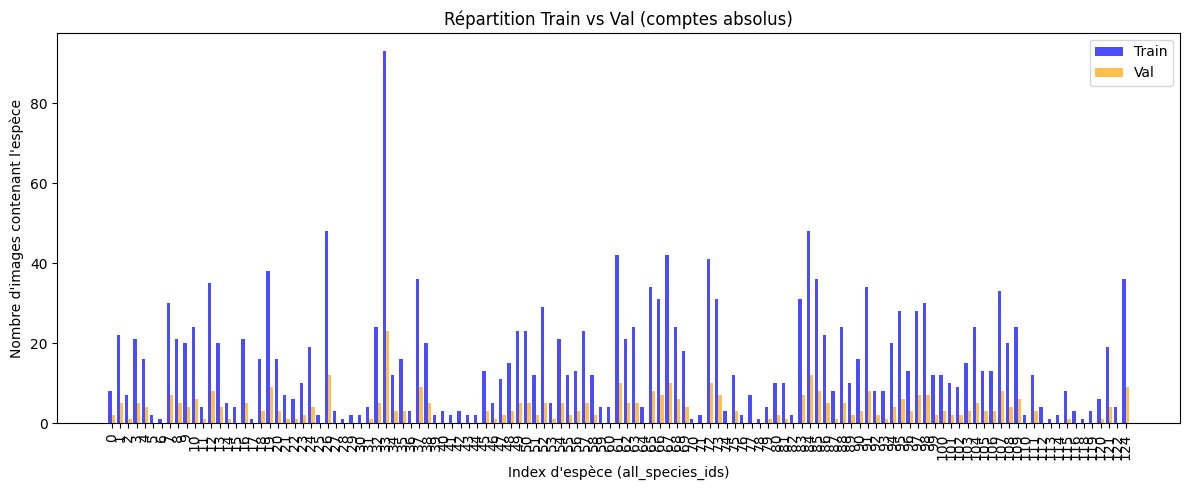

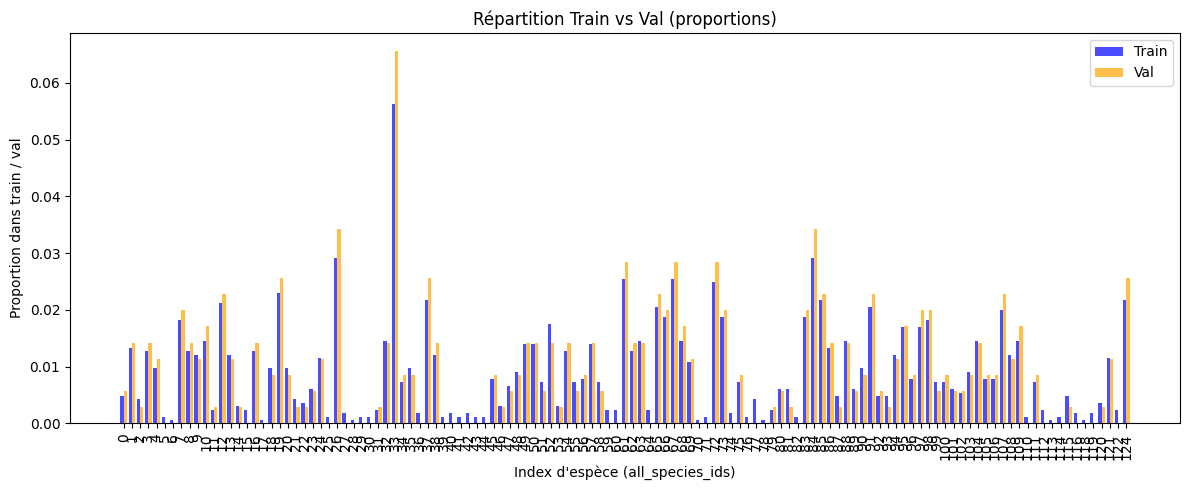

In [2]:
"""Now that the the annotations are ready we want to split the dataset into a traning and a vlidation set to train the model. We use the 80:20 ration. 
However this ratio need to be applied by species accross the full dataset to ensure that the model is trained on all the species. """
"""Here I try the MultilabelStratifiedShuffleSplit librqry to handle the multi label split caused by the presence of several species in the same image."""

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass 

set_seed(42)

%pip install iterative-stratification
%conda install -c conda-forge iterative-stratification -y
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

photo_dir = r"C:\Users\Lucy\Desktop\REDUCE\Phototheque"
label_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"
annotations_csv = r"C:\Users\Lucy\Desktop\REDUCE\annotations.csv"
img_train_dir = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\images\train"
img_val_dir   = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\images\val"
lab_train_dir = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\labels\train"
lab_val_dir   = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\labels\val"

os.makedirs(img_train_dir, exist_ok=True)
os.makedirs(img_val_dir,   exist_ok=True)
os.makedirs(lab_train_dir, exist_ok=True)
os.makedirs(lab_val_dir,   exist_ok=True)

df = pd.read_csv(annotations_csv)

image_to_species = {}
all_species_ids = set()

for _, row in df.iterrows():
    fname = row["file_name"]
    sp_id = row["species_id"]
    if fname not in image_to_species:
        image_to_species[fname] = set()
    image_to_species[fname].add(sp_id)
    all_species_ids.add(sp_id)

all_images = sorted(image_to_species.keys())
all_species_ids = sorted(list(all_species_ids))
species_to_col = {sid: i for i, sid in enumerate(all_species_ids)}

print(f"Nombre total d'images annotées : {len(all_images)}")
print(f"Nombre total d'espèces        : {len(all_species_ids)}")

# -------------------------------------------------------------------------
# 2) CONSTRUIRE LA MATRICE Y POUR MULTILABEL STRATIFICATION
# -------------------------------------------------------------------------
nb_images = len(all_images)
nb_species = len(all_species_ids)

Y = np.zeros((nb_images, nb_species), dtype=int)
for i, img_name in enumerate(all_images):
    for sid in image_to_species[img_name]:
        Y[i, species_to_col[sid]] = 1

# -------------------------------------------------------------------------
# 3) SPLIT MULTILABEL STRATIFIE (~80/20)
# -------------------------------------------------------------------------
msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,  # ratio global de 20% en validation
    random_state=42
)

X = np.arange(nb_images).reshape(-1, 1)

for train_idx, val_idx in msss.split(X, Y):
    train_files = [all_images[i] for i in train_idx]
    val_files   = [all_images[i] for i in val_idx]

print(f"\nSplit initial : {len(train_files)} images en train, {len(val_files)} en val.")

# -------------------------------------------------------------------------
# 4) POST-TRAITEMENT : LIMITER VAL 20% MAXIMUM PAR ESPÈCE
# -------------------------------------------------------------------------
def limit_val_25_percent(train_files, val_files, image_to_species, species_to_col):
    """
    Tant qu'une espèce a plus de 20 de ses images dans val, on déplace 
    UNE image de val->train. Best effort.
    """
    nb_species = len(species_to_col)

    # BOUCLE : on répète tant qu'on fait des modifications
    species_modified = True
    while species_modified:
        species_modified = False

        # Recalcule train_counts / val_counts
        train_counts = np.zeros(nb_species, dtype=int)
        val_counts   = np.zeros(nb_species, dtype=int)

        for f in train_files:
            for sid in image_to_species[f]:
                idx = species_to_col[sid]
                train_counts[idx] += 1
        for f in val_files:
            for sid in image_to_species[f]:
                idx = species_to_col[sid]
                val_counts[idx] += 1

        # Vérifier chaque espèce
        for sid, idx in species_to_col.items():
            total_sp = train_counts[idx] + val_counts[idx]
            if total_sp == 0:
                continue
            ratio_val = val_counts[idx] / total_sp
            if ratio_val > 0.20:
                # => on doit déplacer une image de val->train
                candidate_img = None
                for f in val_files:
                    if sid in image_to_species[f]:
                        candidate_img = f
                        break
                if candidate_img is None:
                    # plus d'images en val pour cette espèce ?
                    continue
                # Déplacement
                val_files.remove(candidate_img)
                train_files.append(candidate_img)
                species_modified = True
                # On arrête la boucle for sid => car on doit re-recompter
                break
    return train_files, val_files

train_files, val_files = limit_val_25_percent(train_files, val_files, image_to_species, species_to_col)

print(f"Après post-traitement : {len(train_files)} images en train, {len(val_files)} en val.")

# -------------------------------------------------------------------------
# 5) COPIE DES FICHIERS
# -------------------------------------------------------------------------
def find_image_path(base_dir, target_img_name):
    """Recherche target_img_name dans base_dir (tous sous-dossiers)."""
    for root, dirs, files in os.walk(base_dir):
        if target_img_name in files:
            return os.path.join(root, target_img_name)
    return None

def copy_image_and_label(img_name, dst_img_dir, dst_lab_dir):
    # 1) Image
    src_img_path = find_image_path(photo_dir, img_name)
    if src_img_path is None:
        print(f"⚠️ Image introuvable : {img_name}")
    else:
        shutil.copy(src_img_path, os.path.join(dst_img_dir, img_name))

    # 2) Label .txt
    base_name, _ = os.path.splitext(img_name)
    label_filename = base_name + ".txt"
    src_label_path = os.path.join(label_dir, label_filename)
    if os.path.isfile(src_label_path):
        shutil.copy(src_label_path, os.path.join(dst_lab_dir, label_filename))
    else:
        print(f"⚠️ Label introuvable : {label_filename}")

# Copier dans train
for f in train_files:
    copy_image_and_label(f, img_train_dir, lab_train_dir)

# Copier dans val
for f in val_files:
    copy_image_and_label(f, img_val_dir, lab_val_dir)

print("✅ Copie des fichiers terminée !")

# -------------------------------------------------------------------------
# 6) TABLEAU FINAL PAR ESPÈCE
# -------------------------------------------------------------------------
train_counts = np.zeros(nb_species, dtype=int)
val_counts   = np.zeros(nb_species, dtype=int)

for f in train_files:
    for sid in image_to_species[f]:
        train_counts[species_to_col[sid]] += 1
for f in val_files:
    for sid in image_to_species[f]:
        val_counts[species_to_col[sid]] += 1

train_total = len(train_files)
val_total   = len(val_files)

print("\nDétails par espèce :\n")
print(" i | Espèce (ID)  | TrainCount | ValCount | %Train(espèce) | %Val(espèce) | %Train(dset) | %Val(dset)")
print("---|--------------|-----------:|---------:|---------------:|-------------:|-------------:|-----------:")

for i, sp_id in enumerate(all_species_ids):
    tc = train_counts[i]
    vc = val_counts[i]
    tot = tc + vc

    if tot > 0:
        sp_train_ratio = 100.0 * tc / tot
        sp_val_ratio   = 100.0 * vc / tot
    else:
        sp_train_ratio = 0.0
        sp_val_ratio   = 0.0

    train_dataset_ratio = (100.0 * tc / train_total) if train_total>0 else 0
    val_dataset_ratio   = (100.0 * vc / val_total)   if val_total>0   else 0

    print(f"{i:2d} | {sp_id:11d}  | {tc:10d} | {vc:8d} | {sp_train_ratio:13.2f}% | {sp_val_ratio:11.2f}% | {train_dataset_ratio:11.2f}% | {val_dataset_ratio:9.2f}%")

# -------------------------------------------------------------------------
# 7) DIAGRAMMES (OPTIONNEL)
# -------------------------------------------------------------------------
x = np.arange(nb_species)
width = 0.4

# (a) Comptes absolus
plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_counts, width=width, color='blue', alpha=0.7, label='Train')
plt.bar(x + width/2, val_counts,   width=width, color='orange', alpha=0.7, label='Val')
plt.xlabel("Index d'espèce (all_species_ids)")
plt.ylabel("Nombre d'images contenant l'espèce")
plt.title("Répartition Train vs Val (comptes absolus)")
plt.legend()
plt.xticks(x, all_species_ids, rotation=90)
plt.tight_layout()
plt.show()

# (b) Proportions dans l'ensemble du train / val
train_props_dataset = [c / train_total for c in train_counts]
val_props_dataset   = [c / val_total   for c in val_counts]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_props_dataset, width=width, color='blue', alpha=0.7, label='Train')
plt.bar(x + width/2, val_props_dataset,   width=width, color='orange', alpha=0.7, label='Val')
plt.xlabel("Index d'espèce (all_species_ids)")
plt.ylabel("Proportion dans train / val")
plt.title("Répartition Train vs Val (proportions)")
plt.legend()
plt.xticks(x, all_species_ids, rotation=90)
plt.tight_layout()
plt.show()

Espèce '3DEY-Diodon-eydouxii': 27 total, 21 en train, 6 en val.
Espèce 'ALB-Thunnus-alalunga': 7 total, 5 en train, 2 en val.
Espèce 'ALM-Aluterus-monoceros': 24 total, 19 en train, 5 en val.
Espèce 'ALN-Aluterus-scriptus': 19 total, 15 en train, 4 en val.
Espèce 'ALS-Carcharhinus-albimarginatus': 2 total, 1 en train, 1 en val.
Espèce 'ALX-Alepisaurus-ferox': 1 total, 0 en train, 1 en val.
Espèce 'BAF-Ablennes-hians': 35 total, 28 en train, 7 en val.
Espèce 'BAO-Platax-teira': 26 total, 20 en train, 6 en val.
Espèce 'BET-Thunnus-obesus': 17 total, 13 en train, 4 en val.
Espèce 'BLM-Istiompax-indica': 30 total, 24 en train, 6 en val.
Espèce 'BLT-Auxis-rochei': 5 total, 4 en train, 1 en val.
Espèce 'BRZ-Bramidae': 2 total, 1 en train, 1 en val.
Espèce 'BSH-Prionace-glauca': 42 total, 33 en train, 9 en val.
Espèce 'BTH-Alopias-superciliosus': 24 total, 19 en train, 5 en val.
Espèce 'BTS-Tylosurus-crocodilus': 14 total, 11 en train, 3 en val.
Espèce 'BUM-Makaira-nigricans': 116 total, 92 e

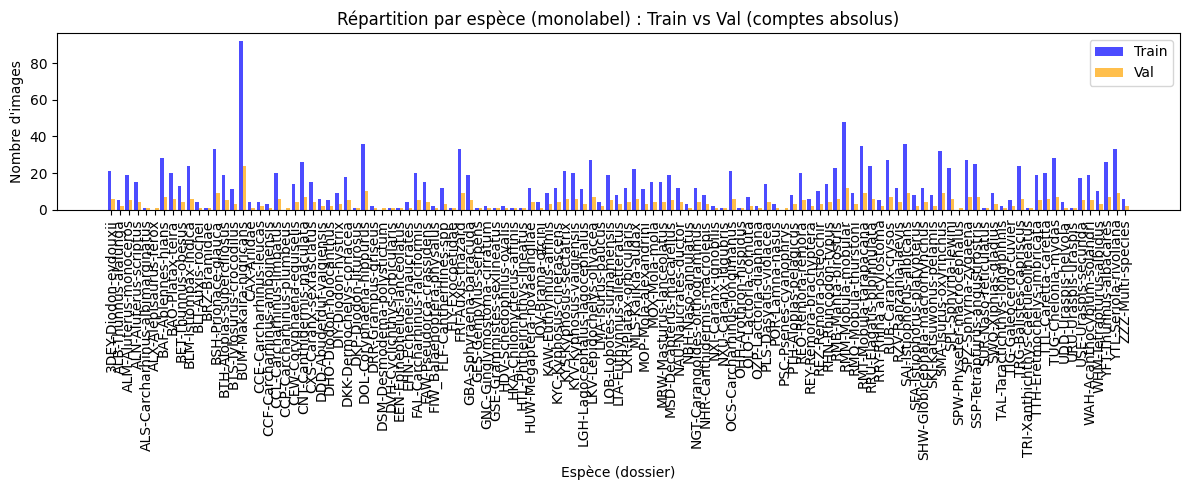

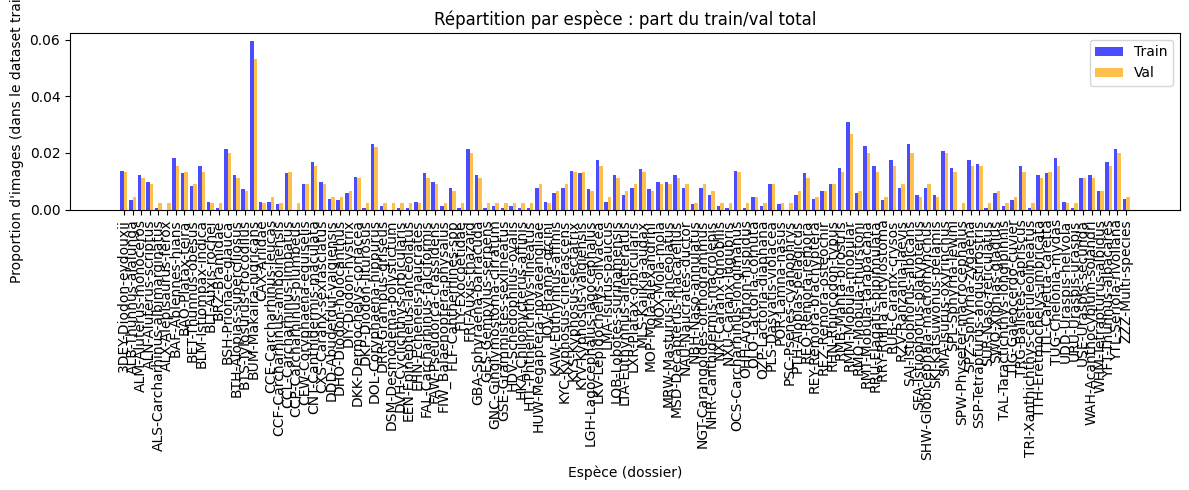

 i | Espèce                       | TrainCount | ValCount | %Train(espèce) | %Val(espèce) | %Train(dset) | %Val(dset)
---|-----------------------------|-----------:|---------:|---------------:|-------------:|-------------:|-----------:
 0 | 3DEY-Diodon-eydouxii         |         21 |         6 |        77.78% |       22.22% |        1.36% |      1.33%
 1 | ALB-Thunnus-alalunga         |          5 |         2 |        71.43% |       28.57% |        0.32% |      0.44%
 2 | ALM-Aluterus-monoceros       |         19 |         5 |        79.17% |       20.83% |        1.23% |      1.11%
 3 | ALN-Aluterus-scriptus        |         15 |         4 |        78.95% |       21.05% |        0.97% |      0.89%
 4 | ALS-Carcharhinus-albimarginatus |          1 |         1 |        50.00% |       50.00% |        0.06% |      0.22%
 5 | ALX-Alepisaurus-ferox        |          0 |         1 |         0.00% |      100.00% |        0.00% |      0.22%
 6 | BAF-Ablennes-hians           |         28 |     

In [ ]:
# Split test without multi lable stratification 
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------------
photo_dir = r"C:\Users\Lucy\Desktop\REDUCE\Phototheque"  
output_dir = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo2\dataset"
train_ratio = 0.8

train_dir = os.path.join(output_dir, "train")
val_dir   = os.path.join(output_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir,   exist_ok=True)

valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Pour mémoriser (espèce -> (train_count, val_count))
species_stats = {}

# -------------------------------------------------------------------------
# Lister les sous-dossiers (1 par espèce), faire le split 80/20
# -------------------------------------------------------------------------
species_folders = [
    d for d in os.listdir(photo_dir) 
    if os.path.isdir(os.path.join(photo_dir, d))
]

for species_name in species_folders:
    species_path = os.path.join(photo_dir, species_name)
    all_images = [
        f for f in os.listdir(species_path)
        if f.lower().endswith(valid_exts)
    ]
    random.shuffle(all_images)
    split_index = int(len(all_images) * train_ratio)
    train_imgs = all_images[:split_index]
    val_imgs   = all_images[split_index:]

    print(f"Espèce '{species_name}': {len(all_images)} total, "
          f"{len(train_imgs)} en train, {len(val_imgs)} en val.")

    species_stats[species_name] = (len(train_imgs), len(val_imgs))

    # Création des dossiers
    sp_train_dir = os.path.join(train_dir, species_name)
    sp_val_dir   = os.path.join(val_dir,   species_name)
    os.makedirs(sp_train_dir, exist_ok=True)
    os.makedirs(sp_val_dir,   exist_ok=True)

    # Copier
    for img in train_imgs:
        shutil.copy(os.path.join(species_path, img), os.path.join(sp_train_dir, img))
    for img in val_imgs:
        shutil.copy(os.path.join(species_path, img), os.path.join(sp_val_dir,   img))

print("✅ Split par dossier (monolabel) terminé !")

# -------------------------------------------------------------------------
# Construire des listes pour la visualisation
# -------------------------------------------------------------------------
all_species = sorted(species_stats.keys())
train_counts = [species_stats[s][0] for s in all_species]
val_counts   = [species_stats[s][1] for s in all_species]

# Comptes globaux
total_train = sum(train_counts)  # somme de toutes les images en train
total_val   = sum(val_counts)

# -------------------------------------------------------------------------
# hisogram
# -------------------------------------------------------------------------
x = np.arange(len(all_species))
width = 0.4

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_counts, width=width, color='blue', alpha=0.7, label='Train')
plt.bar(x + width/2, val_counts,   width=width, color='orange', alpha=0.7, label='Val')
plt.xlabel("Espèce (dossier)")
plt.ylabel("Nombre d'images")
plt.title("Répartition par espèce (monolabel) : Train vs Val (comptes absolus)")
plt.legend()
plt.xticks(x, all_species, rotation=90)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# B) Diagramme (proportions dans l'ensemble)
#    -> % de l'ensemble train et val (pas le ratio par espèce)
# -------------------------------------------------------------------------
train_proportions_dataset = [c / total_train for c in train_counts] if total_train>0 else []
val_proportions_dataset   = [c / total_val   for c in val_counts]   if total_val>0   else []

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_proportions_dataset, width=width, color='blue', alpha=0.7, label='Train')
plt.bar(x + width/2, val_proportions_dataset,   width=width, color='orange', alpha=0.7, label='Val')
plt.xlabel("Espèce (dossier)")
plt.ylabel("Proportion d'images (dans le dataset train/val)")
plt.title("Répartition par espèce : part du train/val total")
plt.legend()
plt.xticks(x, all_species, rotation=90)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# Tableau texte
#    On calcule aussi le pourcentage par rapport à l'ensemble train/val
#    ET le % de distribution interne à l'espèce
# -------------------------------------------------------------------------
print(" i | Espèce                       | TrainCount | ValCount | %Train(espèce) | %Val(espèce) | %Train(dset) | %Val(dset)")
print("---|-----------------------------|-----------:|---------:|---------------:|-------------:|-------------:|-----------:")
for i, sp in enumerate(all_species):
    tc = train_counts[i]
    vc = val_counts[i]
    tot = tc + vc
    # Ratio interne à l'espèce
    if tot > 0:
        sp_train_ratio = 100.0 * tc / tot
        sp_val_ratio   = 100.0 * vc / tot
    else:
        sp_train_ratio = 0
        sp_val_ratio   = 0
    # Ratio sur l'ensemble du train ou val
    ds_train_ratio = 100.0 * tc / total_train if total_train>0 else 0
    ds_val_ratio   = 100.0 * vc / total_val   if total_val>0   else 0
    print(f"{i:2d} | {sp:28s} | {tc:10d} | {vc:9d} | {sp_train_ratio:12.2f}% | {sp_val_ratio:11.2f}% | {ds_train_ratio:11.2f}% | {ds_val_ratio:9.2f}%")



In [3]:
# Another check just in case because there is always issues :(
import os

#  Définir les dossiers des labels et des images
labels_dir = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\labels\train"  # Modifie selon train/val/test
images_dir = r"C:\Users\Lucy\Desktop\REDUCE\models_reduce_yolo\dataset\images\train"

#  Liste des fichiers disponibles
label_files = set(f.replace(".txt", "") for f in os.listdir(labels_dir) if f.endswith(".txt"))
image_files = set(f.rsplit(".", 1)[0] for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".png", ".jpeg")))

#  Trouver les labels sans image correspondante
labels_without_images = label_files - image_files

#  Afficher les fichiers orphelins
if labels_without_images:
    print(" Fichiers .txt sans image correspondante :")
    for label in labels_without_images:
        print(f"  - {label}.txt")
else:
    print(" Tous les labels ont une image correspondante.")

#  Sauvegarder les fichiers orphelins dans un fichier texte
output_path = r"C:\Users\Lucy\Desktop\REDUCE\labels_orphans.txt"
with open(output_path, "w", encoding="utf-8") as f:
    for label in labels_without_images:
        f.write(f"{label}.txt\n")

print(f" Liste des labels orphelins sauvegardée dans {output_path}.")


 Fichiers .txt sans image correspondante :
  - GES_08845ae2eb13d7bf674e2a39e51c4037_GOUE_ORTHONGEL.txt
 Liste des labels orphelins sauvegardée dans C:\Users\Lucy\Desktop\REDUCE\labels_orphans.txt.


In [ ]:
import os
from collections import defaultdict, Counter
" in the intention to get better results we choose to cluster species with less that 10 annotation into a single class called "'rare species'
# paths
annotations_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"
classes_path = r"C:\Users\Lucy\Desktop\REDUCE\classes.txt"
output_classes_path = r"C:\Users\Lucy\Desktop\REDUCE\classes_final.txt"
rare_threshold = 10  # annotation threshold for rare speices 
RARE_SPECIES_NAME = 'rare_species'

#  Get mapping 
id_to_species = {}
with open(classes_path, 'r', encoding='utf-8') as f:
    for line in f:
        if ':' in line:
            parts = line.strip().split(':')
            old_id = int(parts[0].strip())
            species_name = parts[1].strip().strip("'").strip('"')
            id_to_species[old_id] = species_name

# Count annotations per sepcies
annotation_counts = Counter()
for fname in os.listdir(annotations_dir):
    if fname.endswith('.txt'):
        with open(os.path.join(annotations_dir, fname), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    old_id = int(parts[0])
                    annotation_counts[old_id] += 1

# Get rare classes 
rare_ids = {cls_id for cls_id, count in annotation_counts.items() if count < rare_threshold}
print(f"Espèces rares (moins de {rare_threshold} annotations) : {rare_ids}")

# 4️ Construire le nouveau mapping old_id -> new_id
old_to_new = {}
new_id_to_species = {}
new_id = 0

# Conserver les non-rares en réindexant
for old_id in sorted(id_to_species.keys()):
    if old_id not in rare_ids and annotation_counts[old_id] >= rare_threshold:
        old_to_new[old_id] = new_id
        new_id_to_species[new_id] = id_to_species[old_id]
        new_id += 1

# Ajouter la classe rare_species
rare_species_id = new_id
new_id_to_species[rare_species_id] = RARE_SPECIES_NAME
for rid in rare_ids:
    old_to_new[rid] = rare_species_id

print(f"\n Nouveau mapping généré avec rare_species -> ID {rare_species_id}")

# 5️ Réécrire le fichier classes.txt final
with open(output_classes_path, 'w', encoding='utf-8') as f:
    for nid in range(len(new_id_to_species)):
        f.write(f"{nid}: '{new_id_to_species[nid]}'\n")
print(f" Nouveau classes.txt écrit : {output_classes_path}")

# 6️ Mettre à jour les annotations (réécriture)
for fname in os.listdir(annotations_dir):
    if fname.endswith('.txt'):
        full_path = os.path.join(annotations_dir, fname)
        new_lines = []
        with open(full_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    old_id = int(parts[0])
                    new_class = old_to_new.get(old_id)
                    if new_class is not None:
                        parts[0] = str(new_class)
                        new_lines.append(" ".join(parts))
        # Réécrit le label
        with open(full_path, 'w', encoding='utf-8') as fw:
            fw.write("\n".join(new_lines) + "\n")

print("✅ Tous les labels ont été mis à jour avec la nouvelle indexation.")



Espèces rares (moins de 10 annotations) : {2, 5, 6, 11, 14, 15, 17, 22, 25, 27, 28, 29, 30, 31, 36, 39, 40, 41, 42, 43, 44, 46, 53, 59, 60, 64, 70, 71, 74, 76, 78, 79, 82, 87, 93, 110, 112, 113, 114, 115, 116, 118, 119, 120, 122}

 Nouveau mapping généré avec rare_species -> ID 78
 Nouveau classes.txt écrit : C:\Users\Lucy\Desktop\REDUCE\classes_final.txt
✅ Tous les labels ont été mis à jour avec la nouvelle indexation.


In [ ]:

""" function to print specific images that contain a specific class id, it can be usefull to quickly find images on hasty ai if you made annotation mistakes""""
# Dossier contenant les fichiers de labels
labels_dir = r"C:\Users\Lucy\Desktop\REDUCE\test"
# Dossier contenant les images
images_dir = r"C:\Users\Lucy\Desktop\REDUCE\Phototheque"

# Classes à rechercher
target_classes = {"112", "80"}

# Extension d'image (change si c'est .png ou autre)
image_ext = ".jpg"

# Liste des images correspondant aux classes cibles
matching_images = []

# Parcours des fichiers labels
for label_file in os.listdir(labels_dir):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        class_id = line.strip().split()[0]
        if class_id in target_classes:
            # On suppose que le nom de l’image est le même que celui du label
            image_name = os.path.splitext(label_file)[0] + image_ext
            matching_images.append(image_name)
            break  # On passe au fichier suivant dès qu'on trouve une des classes

# Affichage des résultats
print(f"{len(matching_images)} images trouvées contenant la classe 112 ou 80 (macrolepsis) :")
for img in matching_images:
    print(img)


15 images trouvées contenant la classe 112 ou 80 (macrolepsis) :
CNT-NHR_6f2af4491c93b9847688f2dd7c1f3411_HUBERT_IRD.jpg
NHR_095882e2a2ec1822baec1a1bc2d20612_CAUQUIL_IRD.jpg
NHR_1a1823bdf40ca4c75c5fd16b3cad4fb9_BUR_IRD.jpg
NHR_26a0972767194086d6ed72c4df5d2717_EKPO_ORTHONGEL.jpg
NHR_45ce515d3680754896435cf48ed76ae8_LEBORGNE_IRD.jpg
NHR_49e4e1a4049fb826f5f94995f27c9e05_MOUSSY_IRD.jpg
NHR_6554fde00da56d9f901bf2fdc0d64067_MOUSSY_IRD.jpg
NHR_db1b8153ce1cd7321cfc63c3d0348794_RAKOTONIRINA_ORTHONGEL.jpg
NHR_e1ee0784d117bbff681fc111071353b0_BAIDAI_ORTHONGEL.jpg
NHR_ed558d0af30e5e40b347b2d1db397ff8_LEDANTEC_IRD.jpg
NHR_f3351be8baf5ccccb726225b3bac3ad8_JOGUET_ORTHONGEL.jpg
REO_fcf2c87175c45e09b33190da05a5bd93_SIMON_IRD.jpg
SAM_0944.jpg
WHM_1a099e6d262acdb66421fdf3a07547f6_REBOUX_IRD.jpg
WHM_82a8ddb44d1631eee3e45ad9c9f7a202_REBOUX_IRD.jpg
